<div style="background-image:url(images/meschede-seismic-waves.png); padding: 10px 30px 20px 30px; background-size:cover; background-opacity:50%; border-radius:5px">
<p style="float:right; margin-top:20px; padding: 20px 20px 0px 20px; background:rgba(255,255,255,0.6); border-radius:10px;">
<img width="400px" src=images/obspy_logo_full_524x179px.png?raw=true>
</p>

<h1 style="color:#999">ObsPy Workshop</h1>
<h5 style="color:#FFF">Münster, July 7th & 8th</h5>

<h3 style="color:#EEE">Data Acquisition and Processing with ObsPy</h3>

<h2 style="color:#FFF">Handling Event Metadata</h2>
</div>

In [1]:
%pylab inline
from __future__ import print_function
import matplotlib.pylab as plt
plt.style.use('ggplot')
plt.rcParams['figure.figsize'] = 12, 8

Populating the interactive namespace from numpy and matplotlib


- for event metadata, the de-facto standard is [QuakeML (an xml document structure)](https://quake.ethz.ch/quakeml/)
- QuakeML files can be read using **`readEvents()`**

In [2]:
from obspy import readEvents

catalog = readEvents("./data/event_tohoku_with_big_aftershocks.xml")
print(catalog)

5 Event(s) in Catalog:
2011-03-11T05:46:23.200000Z | +38.296, +142.498 | 9.1 MW
2011-03-11T06:15:37.570000Z | +36.227, +141.088 | 7.9 MW
2011-03-11T06:25:50.740000Z | +38.051, +144.630 | 7.6 MW
2011-04-07T14:32:43.290000Z | +38.276, +141.588 | 7.1 MW
2011-07-10T00:57:10.800000Z | +38.034, +143.264 | 7.0 MW


- **`readEvents()`** function returns a **`Catalog`** object, which is
a collection of **`Event`** objects.

In [3]:
print(type(catalog))
print(type(catalog[0]))

<class 'obspy.core.event.Catalog'>
<class 'obspy.core.event.Event'>


In [4]:
event = catalog[0]
print(event)

Event:	2011-03-11T05:46:23.200000Z | +38.296, +142.498 | 9.1 MW

	        resource_id: ResourceIdentifier(id="smi:service.iris.edu/fdsnws/event/1/query?eventid=3279407")
	         event_type: 'earthquake'
	---------
	 event_descriptions: 1 Elements
	            origins: 1 Elements
	         magnitudes: 1 Elements


- Event objects are again collections of other resources.
- the nested ObsPy Event class structure (Catalog/Event/Origin/Magnitude/FocalMechanism/...) is closely modelled after QuakeML
<img src="images/Event.svg" width=90%>

In [5]:
print(type(event.origins))
print(type(event.origins[0]))
print(event.origins[0])

<class 'list'>
<class 'obspy.core.event.Origin'>
Origin
	   resource_id: ResourceIdentifier(id="smi:service.iris.edu/fdsnws/event/1/query?originid=9933375")
	          time: UTCDateTime(2011, 3, 11, 5, 46, 23, 200000)
	     longitude: 142.498
	      latitude: 38.2963
	         depth: 19700.0
	 creation_info: CreationInfo(author='ISC')


In [6]:
print(type(event.magnitudes))
print(type(event.magnitudes[0]))
print(event.magnitudes[0])

<class 'list'>
<class 'obspy.core.event.Magnitude'>
Magnitude
	    resource_id: ResourceIdentifier(id="smi:service.iris.edu/fdsnws/event/1/query?magnitudeid=16642444")
	            mag: 9.1
	 magnitude_type: 'MW'
	      origin_id: ResourceIdentifier(id="smi:service.iris.edu/fdsnws/event/1/query?originid=9933383")
	  creation_info: CreationInfo(author='GCMT')


In [7]:
# try event.<Tab> to get an idea what "children" elements event has

- The Catalog object contains some convenience methods to make
working with events easier.
- for example, the included events can be filtered with various keys.

In [8]:
largest_magnitude_events = catalog.filter("magnitude >= 7.8")
print(largest_magnitude_events)

2 Event(s) in Catalog:
2011-03-11T05:46:23.200000Z | +38.296, +142.498 | 9.1 MW
2011-03-11T06:15:37.570000Z | +36.227, +141.088 | 7.9 MW


- There is a basic preview plot using the matplotlib basemap module.

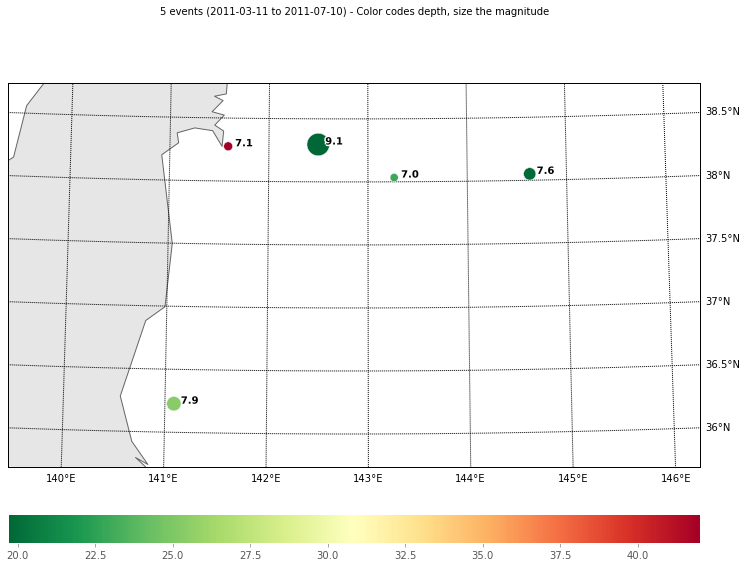

In [9]:
catalog.plot(projection="local");

- a (modified) Catalog can be output to file (currently there is write support for QuakeML only)

In [10]:
largest_magnitude_events.write("/tmp/large_events.xml", format="QUAKEML")
!ls -l /tmp/large_events.xml

-rw-r--r--  1 lion  wheel  3182 Jul  6 14:06 /tmp/large_events.xml


- the event type classes can be used to build up Events/Catalogs/Picks/.. from scratch in custom processing work flows and to share them with other researchers in the de facto standard format QuakeML

In [11]:
from obspy import UTCDateTime
from obspy.core.event import Catalog, Event, Origin, Magnitude
from obspy.core.util.geodetics import FlinnEngdahl

cat = Catalog()
cat.description = "Just a fictitious toy example catalog built from scratch"

e = Event()
e.event_type = "not existing"

o = Origin()
o.time = UTCDateTime(2014, 2, 23, 18, 0, 0)
o.latitude = 47.6
o.longitude = 12.0
o.depth = 10000
o.depth_type = "operator assigned"
o.evaluation_mode = "manual"
o.evaluation_status = "preliminary"
o.region = FlinnEngdahl().get_region(o.longitude, o.latitude)

m = Magnitude()
m.mag = 7.2
m.magnitude_type = "Mw"

m2 = Magnitude()
m2.mag = 7.4
m2.magnitude_type = "Ms"

# also included could be: custom picks, amplitude measurements, station magnitudes,
# focal mechanisms, moment tensors, ...

# make associations, put everything together
cat.append(e)
e.origins = [o]
e.magnitudes = [m, m2]
m.origin_id = o.resource_id
m2.origin_id = o.resource_id

print(cat)
cat.write("/tmp/my_custom_events.xml", format="QUAKEML")
!cat /tmp/my_custom_events.xml

1 Event(s) in Catalog:
2014-02-23T18:00:00.000000Z | +47.600,  +12.000 | 7.2 Mw | manual
<?xml version='1.0' encoding='utf-8'?>
<q:quakeml xmlns:q="http://quakeml.org/xmlns/quakeml/1.2" xmlns="http://quakeml.org/xmlns/bed/1.2">
  <eventParameters publicID="smi:local/705a3509-2774-4cdc-8304-f31709ea39ea">
    <description>Just a fictitious toy example catalog built from scratch</description>
    <event publicID="smi:local/99894c08-6d80-42ba-9d3b-1d3d29c4832b">
      <type>not existing</type>
      <origin publicID="smi:local/80ed430f-2cae-4a33-b4d1-f0c8a018208f">
        <time>
          <value>2014-02-23T18:00:00.000000Z</value>
        </time>
        <latitude>
          <value>47.6</value>
        </latitude>
        <longitude>
          <value>12.0</value>
        </longitude>
        <depth>
          <value>10000.0</value>
        </depth>
        <depthType>operator assigned</depthType>
        <evaluationMode>manual</evaluationMode>
        <evaluationStatus>preliminary</evalu

## Acknowledgements

Background picture at the very top is from Matthias Meschede.